In [20]:
import pennylane as qml
import numpy as np
import jax
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.pyplot as plt


In [21]:
%run reverse_mapping.ipynb

Original expectation value: (-1.1102230246251565e-16-0.9081944666274131j)
Reconstructed expectation value: 0.662601860167484j
Expectation values are not consistent within the threshold.
Unitary matrix U:
 [[-0.06754741+0.65273498j -0.01473623+0.42577198j -0.01473623+0.42577198j
  -0.15815391+0.42586836j]
 [-0.0353509 +0.2805277j  -0.24083787-0.20789815j  0.63674469+0.27152739j
  -0.18282119-0.55338548j]
 [-0.0353509 +0.2805277j   0.63674469+0.27152739j -0.24083787-0.20789815j
  -0.18282119-0.55338548j]
 [ 0.63982965-0.01007205j -0.4385717 +0.213917j   -0.4385717 +0.213917j
   0.00857712-0.3379819j ]]
Hamiltonian:
[[ 2.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  0.+0.j]]
Density Matrix ρ:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j]]
Original expectation value: (1.0211421786396893+0j)
Reconstructed expectation value: (1.0211421

# Define Random Hamiltonian

In [22]:
#Stochastic Parameter-Shift Rule

num_wires = 6
wires = list(range(num_wires))
np.random.seed(62213)

coefficients = np.random.randn(4**num_wires - 1)
# Create the matrices for the entire Pauli basis
basis = qml.ops.qubit.special_unitary.pauli_basis_matrices(num_wires)
# Construct the Hamiltonian from the normal random coefficients and the basis
H_matrix = qml.math.tensordot(coefficients, basis, axes=[[0], [0]])
H = qml.Hermitian(H_matrix, wires=wires)
# # Compute the ground state energy
E_min = min(qml.eigvals(H))
print(f"Ground state energy: {E_min:.5f}")

Ground state energy: -119.70320


In [23]:
def two_qubit_decomp(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    
    i, j = wires
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[:3], wires=i)
    qml.Rot(*params[3:6], wires=j)
    qml.CNOT(wires=[j, i])  # First CNOT
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])  # Second CNOT
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])  # Third CNOT
    # Single U(2) parameterization on both qubits separately
    qml.Rot(*params[9:12], wires=i)
    qml.Rot(*params[12:15], wires=j)

In [24]:
def two_qubit_decomp_1(params, wires):
    """Implement an arbitrary SU(4) gate on two qubits
    using the decomposition from Theorem 5 in
    https://arxiv.org/pdf/quant-ph/0308006.pdf"""
    
    i, j = wires    
    qml.RZ(params[0], wires=i)
    qml.RY(params[1], wires=i)
    qml.RZ(params[2], wires=i)
    qml.RZ(params[3], wires=j)
    qml.RY(params[4], wires=j)
    qml.RZ(params[5], wires=j)
    qml.CNOT(wires=[j, i])
    qml.RZ(params[6], wires=i)
    qml.RY(params[7], wires=j)
    qml.CNOT(wires=[i, j])
    qml.RY(params[8], wires=j)
    qml.CNOT(wires=[j, i])
    qml.RZ(params[9], wires=j)
    qml.RY(params[10], wires=j)
    qml.RZ(params[11], wires=j)
    qml.RZ(params[12], wires=i)
    qml.RY(params[13], wires=i)
    qml.RZ(params[14], wires=i)


In [33]:
# Initialize parameters for different circuit repetitions
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))

repetitions = [1,4,6,8,10]
param_shapes = [(rep, 2, 3, d) for rep in repetitions]


def create_params_decomp_su4(init_params_list):
    init_params_list1 = [np.zeros(shape) for shape in param_shapes]
    for rep_index,init_params in enumerate(init_params_list):
        for block_idx, params_block in enumerate(init_params):
            for layer_idx, params_layer in enumerate(params_block):
                for op_idx, params_op in enumerate(params_layer):
                    # Update the element in the original list
                    init_params_list1[rep_index][block_idx][layer_idx][op_idx] = rev_map(params_op)

    return init_params_list1
# create_params(init_params_list)



In [38]:
#num_wires = 4  # Number of qubits
loc = 2  # Local dimension for two-qubit operations
d = loc**4 - 1  # Number of parameters for two-qubit operations (15 for SU(4))
dev = qml.device("default.qubit", wires=num_wires)

# Initialize parameters for different circuit repetitions
repetitions = [2,4,6,8,10]
param_shapes = [(rep, 2, 3, d) for rep in repetitions]

#init_params_list = [np.random.randn(*shape) for shape in param_shapes] # give same initial parameters for each repetitions

init_params_list = [np.ones(shape) for shape in param_shapes] # give same initial parameters for each repetitions

#Near-Identity Initialization

# Define the small random noise to be added to each element
epsilon = 1e-2  # This defines the magnitude of the random noise

# Create the initial parameters list with small random noise added to each element
#init_params_list = [np.zeros(shape) + epsilon * np.random.randn(*shape) for shape in param_shapes]

init_params_list1 = create_params_decomp_su4(init_params_list)




C:\Users\DELL\AppData\Local\Temp\ipykernel_26236\3756046989.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  init_params_list1[rep_index][block_idx][layer_idx][op_idx] = rev_map(params_op)


# Block Architecture for SU(4) Operator

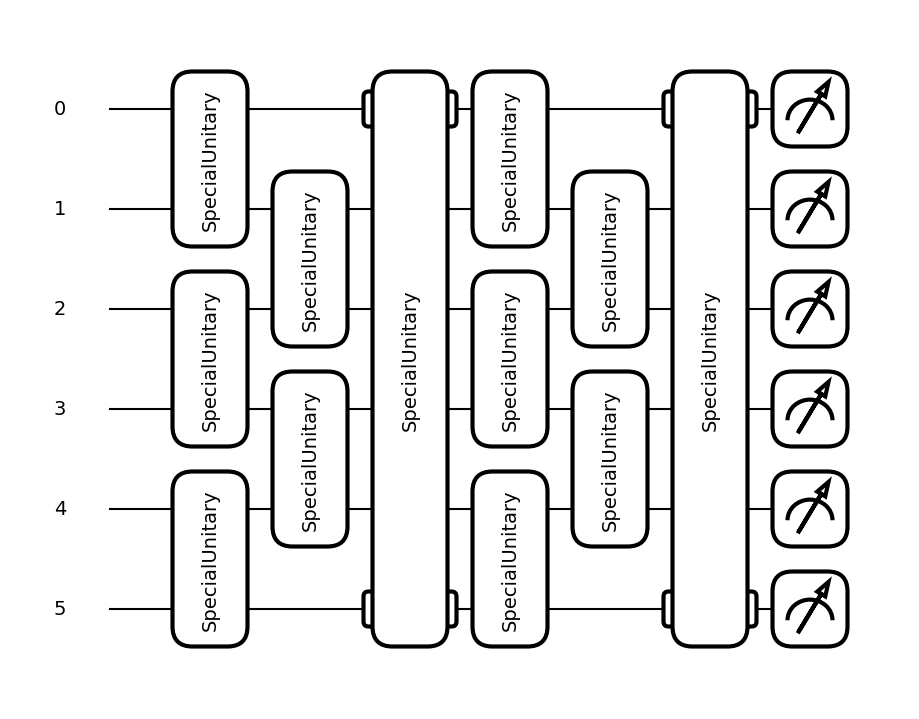

In [39]:

# Define the quantum circuit function
def circuit(params, operation=None):
    """Apply an operation in a brickwall-like pattern to a qubit register and measure H.
    Parameters are assumed to have the dimensions (number of blocks, number of
    wires per operation, number of operations per layer, and number of parameters
    per operation), in that order.
    """
    for params_block in params:
        for i, params_layer in enumerate(params_block):
            for j, params_op in enumerate(params_layer):
                wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                #wires_op = [(loc * j + i + w) % num_wires for w in range(loc)]
                operation(params_op, wires_op)
    return qml.expval(H)

# Create QNodes for different circuit repetitions
qnodes = [qml.QNode(circuit, dev, interface="jax") for _ in repetitions]


#qml.draw(qnodes[-1])(init_params_list[-1],qml.SpecialUnitary )#(output = "mpl") #two_qubit_decomp_1

#dev._circuit.draw(output="mpl")

# # Drawing the last QNode with the last set of initial parameters using SpecialUnitary
# fig, ax = qml.draw_mpl(qnodes[0])(init_params_list[0], two_qubit_decomp_1)

# # Display the circuit
# plt.show()


# Drawing the last QNode with the last set of initial parameters using SpecialUnitary
fig, ax = qml.draw_mpl(qnodes[0])(init_params_list[0], qml.SpecialUnitary)

# Display the circuit
plt.show()

In [28]:
learning_rate = 5e-4
num_steps = 1000
#grad_fn = jax.jit(jax.jacobian(qnode), static_argnums=1)

# Define a function to run optimization for each circuit repetition
def optimize(i, operation): # i stands for repetition index
    # Select the appropriate initial parameters list
    if operation == two_qubit_decomp_1:
        params = init_params_list[i]
    else:
        params = init_params_list1[i]
    grad_fn = jax.jit(jax.jacobian(qnodes[i]), static_argnums=1)
    energies = []
    #params = init_params_list[i]
    #qnode
    for step in range(num_steps):
        cost = qnodes[i](params,operation)
        params = params - learning_rate * grad_fn(params, operation)
        energies.append(cost)
    energies.append(cost)
    return energies



In [29]:
def calculate_errors(repetitions,operation, E_min):

    """
    Calculate the relative errors for a set of circuit repetitions and save them to a file.

    Parameters:
    repetitions (list): List of circuit repetitions.
    operation (qml.Operation): The quantum operation to be used.
    E_min (float): The minimum energy value to compute the relative error.

    Returns:
    dict: A dictionary with repetitions as keys and relative error arrays as values.
    """

    # Initialize the error dictionary
    error_dict = {}

    for i, rep in enumerate(repetitions):
        # Calculate the energy values
        e = optimize(i, operation)
        
        # Compute the relative error
        error = (e - E_min) / abs(E_min)
        
        # Store the errors in the dictionary
        error_dict[rep] = error

    # Example details
    hamiltonian_info = "Random_Hamiltonian"

    operation_info = 'SU' if operation == qml.SpecialUnitary else '2_Qub_Decomp'

    num_qubits = num_wires
    param_info = 'ones_mapped'

    # Construct the filename
    filename = f"{hamiltonian_info}_{operation_info}_{num_qubits}_{param_info}.pkl"

    # Define the folder where you want to save the file
    folder_path ='C:/Users/DELL/OneDrive/Documents/GitHub/SUN-circuits/Graphs/Plot_Data' #'C:/Users/DELL/Downloads/dataset_4_9_training.csv'  # 'path/to/your/folder' data = np.loadtxt(
    # Replace with your folder path
    # Ensure the folder exists
    os.makedirs(folder_path, 
                exist_ok=True)

    file_path = os.path.join(folder_path, 
                             filename)

    # # # Save the dictionary to the specified folder with the constructed filename
    try:
        # Save the dictionary to the specified folder with the constructed filename
        with open(file_path, 'wb') as f:
            pickle.dump(error_dict, f)
        print(f"Dictionary successfully saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while saving the dictionary: {e}")
    return error_dict

calculate_errors(repetitions,two_qubit_decomp_1,E_min)
calculate_errors(repetitions,qml.SpecialUnitary,E_min)




c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritiz

Dictionary successfully saved to C:/Users/DELL/OneDrive/Documents/GitHub/SUN-circuits/Graphs/Plot_Data\Random_Hamiltonian_2_Qub_Decomp_6_ones_mapped.pkl


c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\jax\_src\lax\lax.py:2745: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
c:\Users\DELL\anaconda3\envs\qiskit\Lib\site-packages\pennylane\math\utils.py:227: UserWarning: Contains tensors of types {'autograd', 'jax'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warning

Dictionary successfully saved to C:/Users/DELL/OneDrive/Documents/GitHub/SUN-circuits/Graphs/Plot_Data\Random_Hamiltonian_SU_6_ones_mapped.pkl


{2: array([0.93845683, 0.884304  , 0.83566344, ..., 0.03089045, 0.0308856 ,
        0.0308856 ], dtype=float32),
 4: array([9.3387818e-01, 8.4389913e-01, 7.6734400e-01, ..., 3.6233876e-04,
        3.6049041e-04, 3.6049041e-04], dtype=float32),
 6: array([ 9.6132725e-01,  8.4305048e-01,  7.3830122e-01, ...,
        -6.3735925e-08, -3.8241555e-07, -3.8241555e-07], dtype=float32),
 8: array([1.0511851e+00, 8.5599011e-01, 6.8179888e-01, ..., 1.2747185e-07,
        1.2747185e-07, 1.2747185e-07], dtype=float32),
 10: array([ 1.0299531e+00,  7.6982218e-01,  6.0340226e-01, ...,
         5.7362337e-07, -6.3735925e-08, -6.3735925e-08], dtype=float32)}

In [30]:
# Load the Dictionary

file_path_1 ='C:/Users/DELL/OneDrive/Documents/GitHub/SUN-circuits/Graphs/Plot_Data/Random_Hamiltonian_SU_6_rand_mapped.pkl'
file_path_2 = 'C:/Users/DELL/OneDrive/Documents/GitHub/SUN-circuits/Graphs/Plot_Data/Random_Hamiltonian_2_Qub_Decomp_6_rand_mapped.pkl'
# Loading the dictionary (for reference)

# Loading the dictionaries
with open(file_path_1, 'rb') as f:
    dict1 = pickle.load(f)

with open(file_path_2, 'rb') as f:
    dict2 = pickle.load(f)


def convert_error_to_e(error, E_min):
    return error * abs(E_min) + E_min

# Convert all error values in dict1 and dict2
for rep in dict1:
    dict1[rep] = [convert_error_to_e(error, E_min) for error in dict1[rep]]

for rep in dict2:
    dict2[rep] = [convert_error_to_e(error, E_min) for error in dict2[rep]]

# Print the converted dictionaries (optional)
print(dict1)
print(dict2)

{2: [3.0476725458797347, -1.1510466269832307, -5.45785189425176, -9.771221238809431, -14.004658672638627, -18.101128071990047, -22.032396769653772, -25.78812634389942, -29.36294424016316, -32.74882373349905, -35.933371560590516, -38.90328833006045, -41.648442531310394, -44.16545223756313, -46.458855223988095, -48.54018856990761, -50.42639044867431, -52.137524105219754, -53.694822902600976, -55.11919913487718, -56.43058761938081, -57.646932545657705, -58.78416607086727, -59.85605492015014, -60.874100498495544, -61.84805616857114, -62.78556337252548, -63.69281517458354, -64.57458480051316, -65.43458238095604, -66.27545851886103, -67.09922524661452, -67.90749147663905, -68.70121684849482, -69.48132175997563, -70.24835916324443, -71.00283563383114, -71.7451542916997, -72.47566117788114, -73.1946095801404, -73.9022420839425, -74.59877630271933, -75.28442271503613, -75.9592491021258, -76.62326616628825, -77.2765238515898, -77.91893653963103, -78.55041147714593, -79.17084164113518, -79.779905

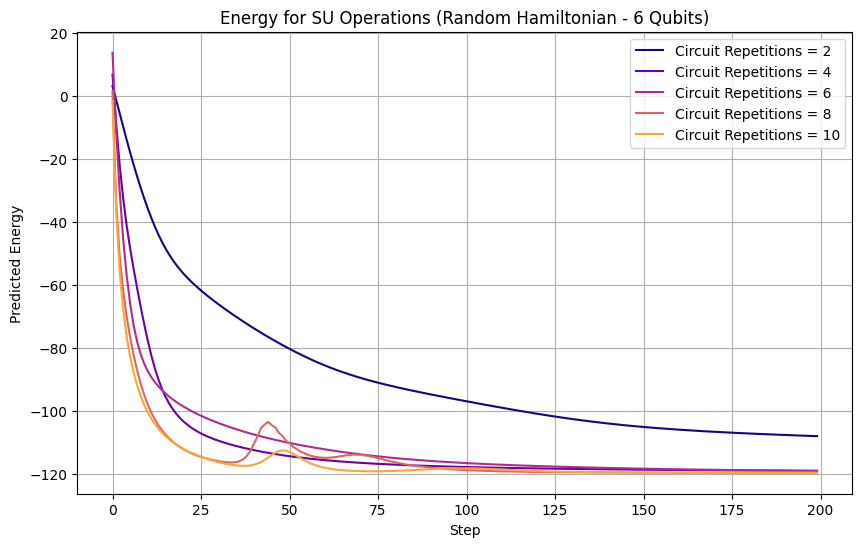

In [31]:
plt.figure(figsize=(10, 6))
error_dict = dict1
for i, (rep, error) in enumerate(error_dict.items()):
    color = plt.cm.plasma(i / len(error_dict))  # Get color from a colormap
    plt.plot(np.arange(len(error)-801), error[:200], color=color, label=f"Circuit Repetitions = {rep}")  # Label each curve

#plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title("Energy for SU Operations (Random Hamiltonian - 6 Qubits)")
plt.xlabel("Step")
plt.ylabel("Predicted Energy")
#plt.ylabel("Relative Error (log scale)")
plt.legend()
plt.grid(True)
plt.show()

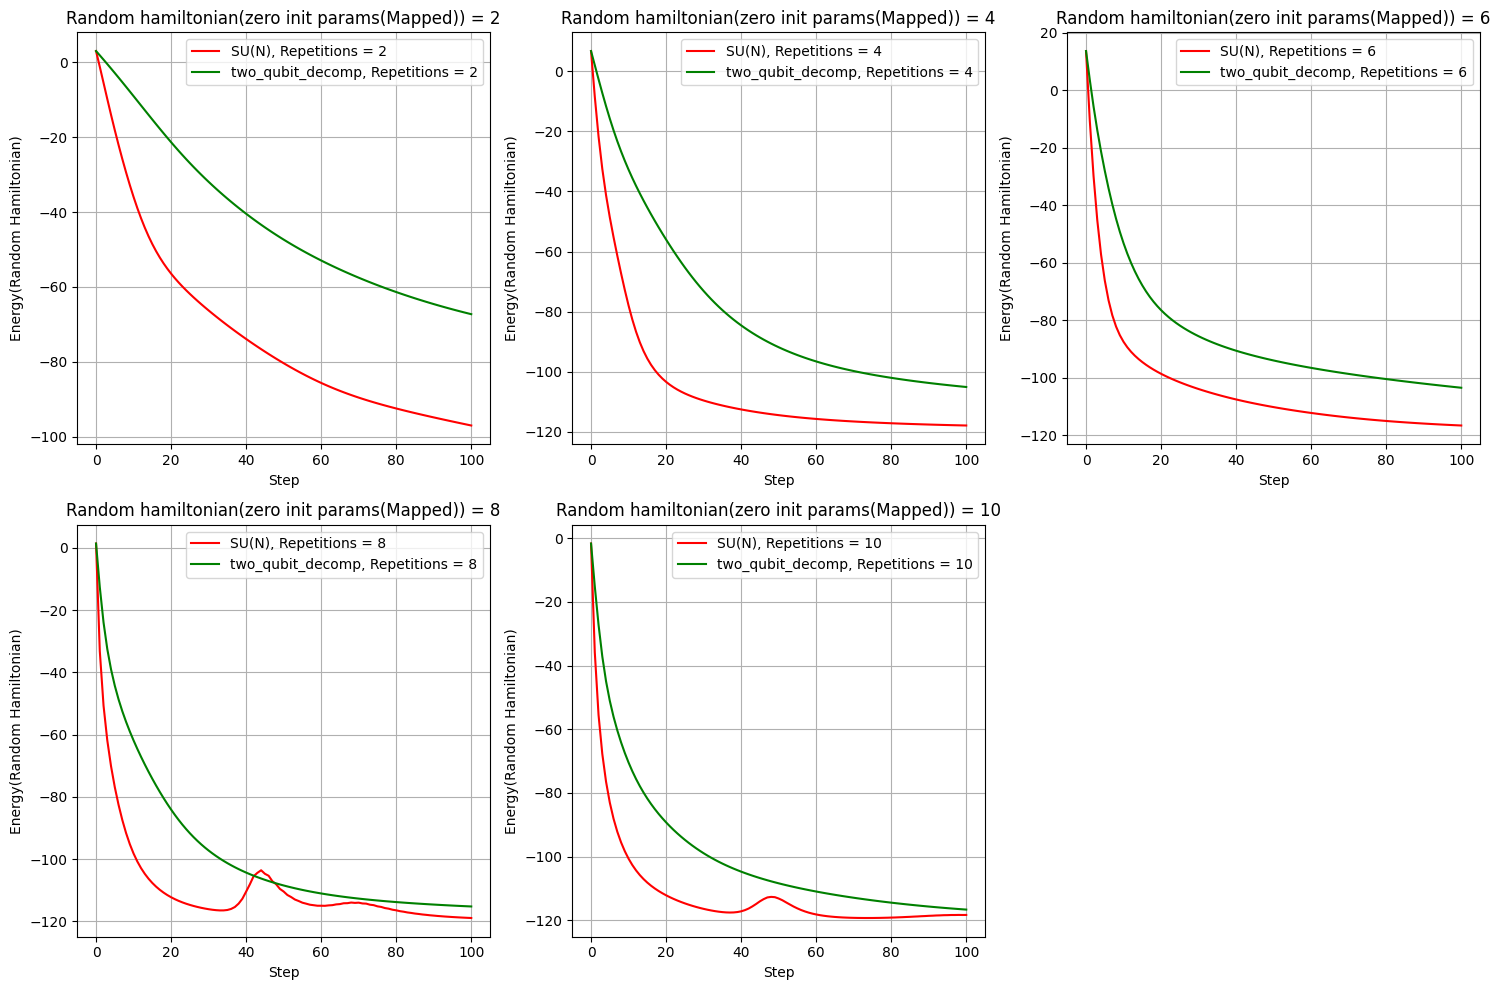

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pickle

# Assuming the dictionaries dict1 and dict2 are already loaded and contain the necessary data

# Define the number of steps to restrict to 600
restricted_steps = 100

# Create the subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop over repetitions and create subplots
for i, rep in enumerate(repetitions):
    if i < len(axes):  # Ensure there are enough subplots
        ax = axes[i]
        
        # Plot data from dict1
        ax.plot(np.arange(restricted_steps + 1), dict1[rep][:restricted_steps + 1], color="red", label=f"SU(N), Repetitions = {rep}")
        
        # Plot data from dict2
        ax.plot(np.arange(restricted_steps + 1), dict2[rep][:restricted_steps + 1], color="green", label=f"two_qubit_decomp, Repetitions = {rep}")
        
        # Set plot title and labels
        #
        # ax.set_yscale('log')
        ax.set_title(f"Random hamiltonian(zero init params(Mapped)) = {rep}")
        ax.set_xlabel("Step")
        ax.set_ylabel("Energy(Random Hamiltonian)")
        #ax.set_ylabel("Relative Error (log Scale)")
        ax.legend()
        ax.grid(True)

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
